# Install Requirements (Expects CUDA 11.0)

In [1]:
!pip install gdown==4.2.0 tensorflow==2.4.1 numpy==1.19.5 scikit-image==0.17.2 librosa==0.8.0 matplotlib==3.3.3 scipy==1.5.4

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


# Setup Tensorflow on GPU(s)

In [4]:
SELECTED_GPUS = [4]  # which GPUs to use

import os

os.environ['CUDA_VISIBLE_DEVICES'] = ','.join([str(gpu_number) for gpu_number in SELECTED_GPUS])

import tensorflow as tf 

tf.get_logger().setLevel('INFO')

GPUS = tf.config.experimental.list_physical_devices('GPU')
for gpu in GPUS:
    tf.config.experimental.set_memory_growth(gpu, True)

# Download Pre-Trained Model

In [3]:
import gdown

model_path = 'av_cc_backbone_v10.h5'
gdown.download(
    'https://docs.google.com/uc?export=download&id=1QUYxgIK3irx_IzlSmtis0hTThxxivGI4',
    model_path,
    quiet=False
)

Downloading...
From: https://docs.google.com/uc?export=download&id=1QUYxgIK3irx_IzlSmtis0hTThxxivGI4
To: /tf/2021_11_CC_exercise/av_cc_backbone_v10.h5
100%|██████████| 274M/274M [00:03<00:00, 90.6MB/s] 


'av_cc_backbone_v10.h5'

# Download and Unzip Data

In [2]:
import gdown

gdown.download(
    'https://docs.google.com/uc?export=download&id=1rdWKu_VhI-Qe5OqoiwkHaQJBXwTmShTZ',
    'samples.zip',
    quiet=False
)  

Downloading...
From: https://docs.google.com/uc?export=download&id=1rdWKu_VhI-Qe5OqoiwkHaQJBXwTmShTZ
To: C:\Demo\Updated\samples.zip
100%|█████████████████████████████████████████████████████████████████████████████| 2.56M/2.56M [00:00<00:00, 29.6MB/s]


'samples.zip'

In [5]:
!apt-get install unzip
!unzip samples.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 48 not upgraded.


# Download and Modify the Code for Extracting Spectrograms from Raw Audio

In [5]:
import urllib.request

download_list = [
    (
        'https://raw.githubusercontent.com/DTaoo/VGGish/master/mel_features.py',
        'mel_features.py'
    ),
    (
        'https://raw.githubusercontent.com/DTaoo/VGGish/master/preprocess_sound.py',
        'preprocess_sound.py'
    ),
    (
        'https://raw.githubusercontent.com/DTaoo/VGGish/master/vggish_params.py',
        'vggish_params.py'
    )
]

for url, file_path in download_list:
    if not os.path.exists(file_path):
        urllib.request.urlretrieve(url, file_path)

In [6]:
# Solving this issue: https://github.com/DTaoo/VGGish/issues/11
params_path = 'vggish_params.py'
with open(params_path, 'rt') as read_file:
    text = read_file.read()
with open(params_path, 'wt') as write_file:
    write_file.write(text.replace('496', '96').replace('4.96', '0.96'))

# Read Input Data and Retrieve Model Output

In [19]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from preprocess_sound import preprocess_sound
from skimage.transform import resize

sample_number = 1  # 1 to 5
head_annotation_path = 'samples/%d.mat' % sample_number
image_path = 'samples/%d.jpg' % sample_number
audio_path = 'samples/%d.wav' % sample_number
sampling_rate = 48000

head_annotation = scipy.io.loadmat(head_annotation_path)['map']
count = np.sum(head_annotation)

image = plt.imread(image_path, format='jpeg')
resized_image = resize(image, (576, 1024))

waveform, _ = librosa.load(audio_path, sr=sampling_rate)
mel_spectrogram = preprocess_sound(waveform, sampling_rate)
mel_spectrogram = np.moveaxis(mel_spectrogram, 0, -1)

model = tf.keras.models.load_model(model_path, compile=False)
density_map_prediction = model([
    np.expand_dims(mel_spectrogram, axis=0),
    np.expand_dims(resized_image, axis=0)
])
count_prediction = np.sum(density_map_prediction)

# Visualize Input Data and Model Output

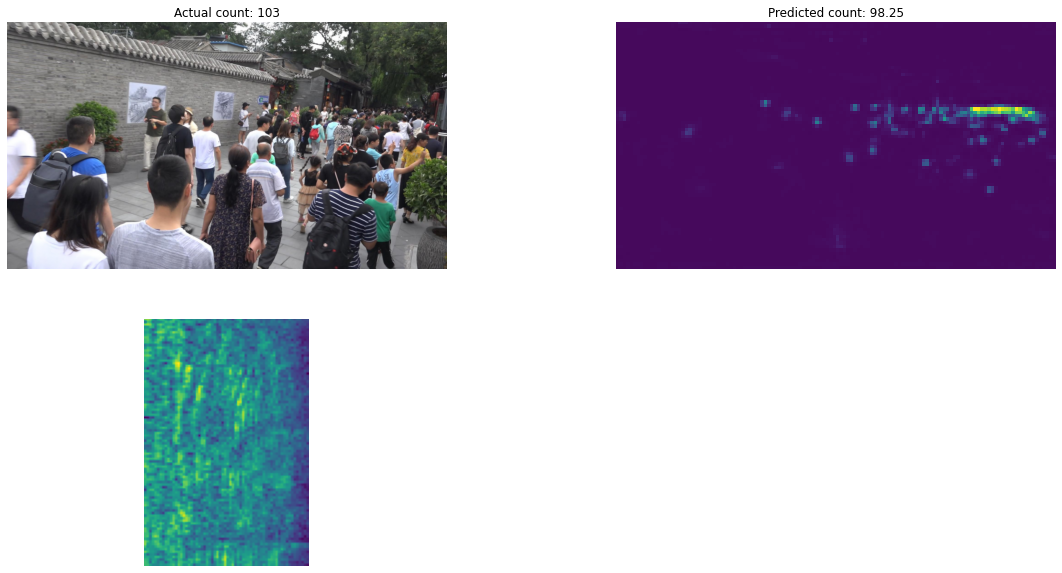

In [20]:
def visualize_data(image, density_map, spectrogram, count, count_prediction):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))
    fig.delaxes(ax4)
    ax1.imshow(image)
    ax1.set_title('Actual count: %d' % count)
    ax2.imshow(density_map)
    ax2.set_title('Predicted count: %.2f' % count_prediction)
    ax3.imshow(spectrogram)
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    plt.show()

visualize_data(resized_image, density_map_prediction[0], mel_spectrogram, count, count_prediction)